# Building a Generative Adversarial Network (GAN) to Generate MNIST Digits
## Erkin Polat

In this project I will be building a GAN to generate images similar to the MNIST handwritten digits dataset. Then I will discuss how to avoid some of the failure modes that I encourntered while doing this project.

GANs are great tools for generating data that is similar to some already existing data. They also have specialized versions such as Conditional GANs that work with labeled data or CycleGANs that do image to image translation. 

In this project we will implement a vanilla GAN. GANs consist of two networks stacked together. These are the generator and the discriminator networks. Generator network creates new data from a noise input and the discriminator tries to tell whether an input is real or fake (created by the generator). These two networks play a zero-sum game where the weights and biases of the discriminator are updated to minimize its loss, while the weights and biases of the generator are updated to maximize the discriminator's loss. In the end, after enough training, we aim to achieve a discriminator accuracy around 50%, which means it cannot distinguish between the generated and real data.

Let's get started!

Note 1: I made this project in Google Colab by mounting my own drive, if you want to replicate it, make sure to specify your directories accordingly.

Note 2: I took the outputs from the same random noise after each epoch and converted them into a GIF. You can check it out from this link: https://gph.is/g/EG8DDpp

In [408]:
#Mounting Google Drive
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [409]:
#Setting the directory to a folder in the drive
%cd /content/gdrive/My\ Drive/GAN

/content/gdrive/My Drive/GAN


In [410]:
#Checking the directory
print( os.getcwd() )

/content/gdrive/My Drive/GAN


In [305]:
#Importing the dependencies
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU Activation
from keras.models import Sequential
from keras.optimizers import Adam

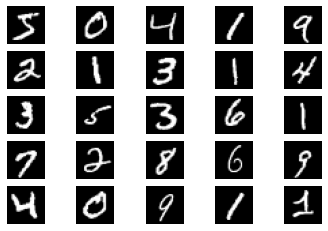

In [405]:
#Loading the dataset

from keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

#Plotting sample images
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray')
plt.show()

In [389]:
#Normalizing and flattening the data
#The way we preprocess like this is so that it matches the output of the tanh layer
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

X_train = X_train.reshape(-1, 28*28)

In [407]:
data_dim = X_train.shape

In [406]:
#Creating the generator network
def generator():
  #Specifying the dimension of the data for the output
  dim= data_dim[1:]

  #Create a sequential model
  generator = Sequential()
  
  #Add a couple of dense layer with LeakyReLU activation.
  generator.add(Dense(256, input_dim=100))
  generator.add(LeakyReLU())

  generator.add(Dense(512))
  generator.add(LeakyReLU())

  generator.add(Dense(1024))
  generator.add(LeakyReLU())

  #Using tanh activation at the final layer. The data dimension is outputted
  generator.add(Dense(np.prod(dim), activation='tanh'))

  return generator

  #I think it is important to note that we don't compile this model here with an optimizer. It will be using the optimizer of the bigger GAN model

In [394]:
#Creating the discriminator
def discriminator():
  #We use this for the input size
  dim= data_dim[1:]
  
  #Creating a sequential model
  discriminator = Sequential()

  #Adding layers that mirror the generator network. This isn't necessary, but is useful
  discriminator.add(Dense(1024, input_dim=np.prod(dim)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(100))
  #Using sigmoid activation for binary classification
  discriminator.add(Dense(1, activation='sigmoid'))

  #Adding the adam optimizer. Note that the learning rate is very low compared to the default setting
  opt = Adam(learning_rate=0.0002, beta_1=0.5)

  #Compiling the model
  discriminator.compile(loss='binary_crossentropy', optimizer=opt)

  return discriminator

In [395]:
#Creating instances of the generator and the discriminator
generator = generator()
discriminator = discriminator()

In [397]:
#Looking at the summaries of the models
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [398]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)              

In [399]:
def define_gan(generator, discriminator):
	#Making the discriminator weights untrainable. This doesn't effect them when the discriminator is being trained
  #But when the generator is trained they are unchanged
	discriminator.trainable = False

  #Putting the discriminator and the generator in a sequential model
	model = Sequential()
	model.add(generator)
	model.add(discriminator)

  #Compiling the model with the Adam optimizer. We again use a low learning rate. This will update the generator network
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	
  return model

In [400]:
gan = define_gan(generator, discriminator)

In [401]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1485769   
Total params: 2,972,121
Trainable params: 1,486,352
Non-trainable params: 1,485,769
_________________________________________________________________


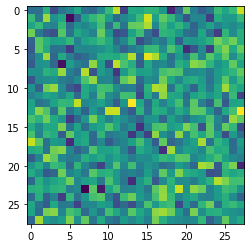

In [383]:
#Generating a sample output from the untrained generator
sample_out = generator.predict(np.random.normal(0, 1, size=(100, 1)).reshape(1,100))
plt.imshow(sample_out.reshape(28, 28))

In [385]:
#Function to plot the generated data and save them

def show_images(noise, epoch):

  #Generating images from the inputted noise
  images=generator.predict(noise)
  
  #Creating a plot
  plt.figure(figsize = (20, 20))

  #Looping for each image
  for i in range(noise.shape[0]):
    #Creating a subplot
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')

    #Plotting the image
    plt.imshow(images[i].reshape(28, 28), cmap='gray')

  #Saving the images to the drive (or locally) with a proper name
  name = 'images_after_epoch_' + str(epoch) + '.png'
  plt.savefig(name, bbox_inches='tight')

  #Displaying the plot
  plt.show()

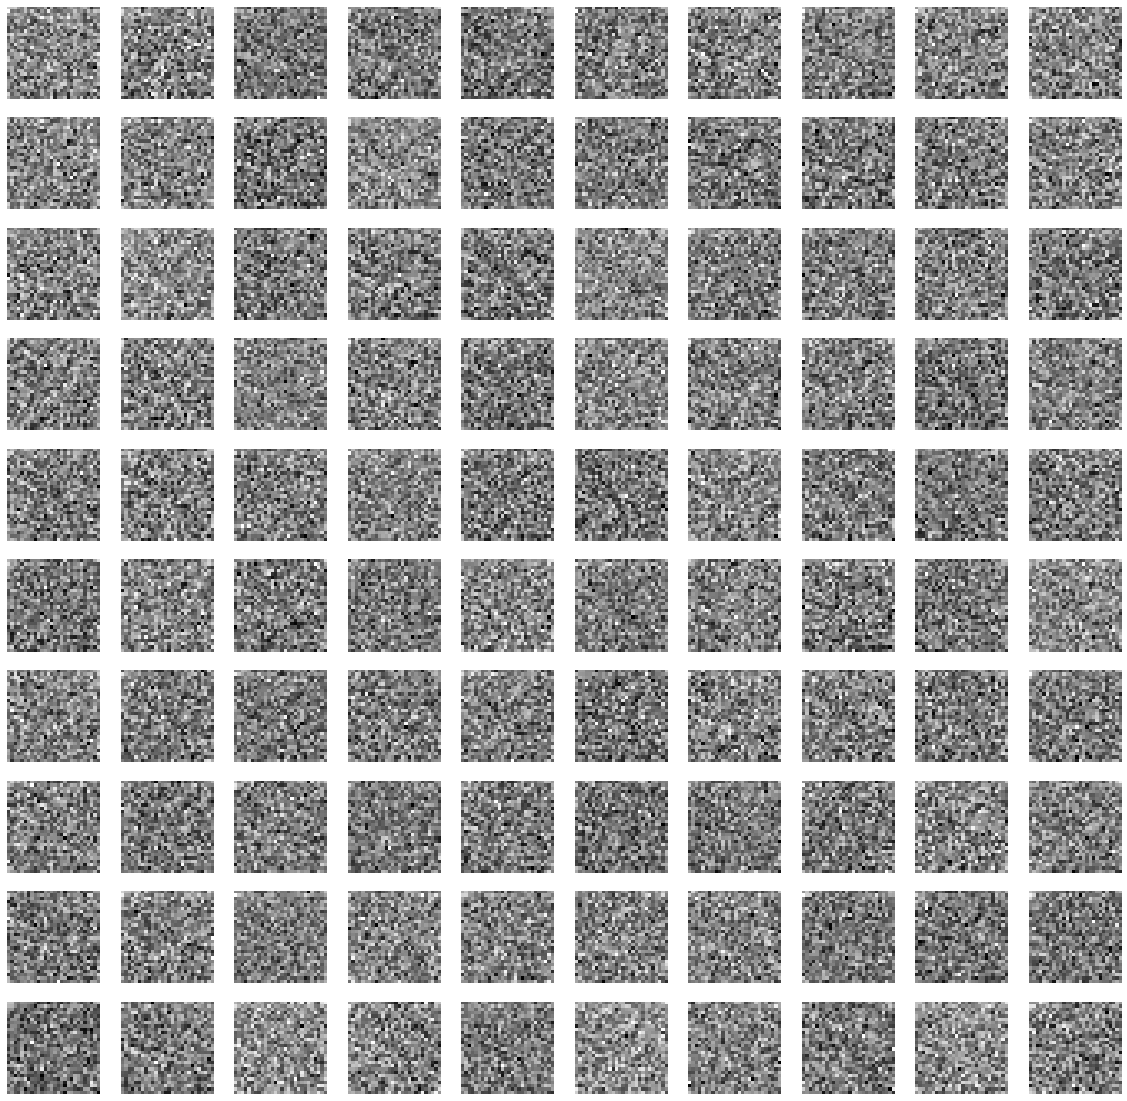

In [258]:
#Generating a sample batch of images from random noise
show_images(np.random.normal(0, 1, size=(100, 100)), 0)

Epoch: 0, Generator Loss: 1.812778353691101, Discriminator Loss: 0.5496151447296143


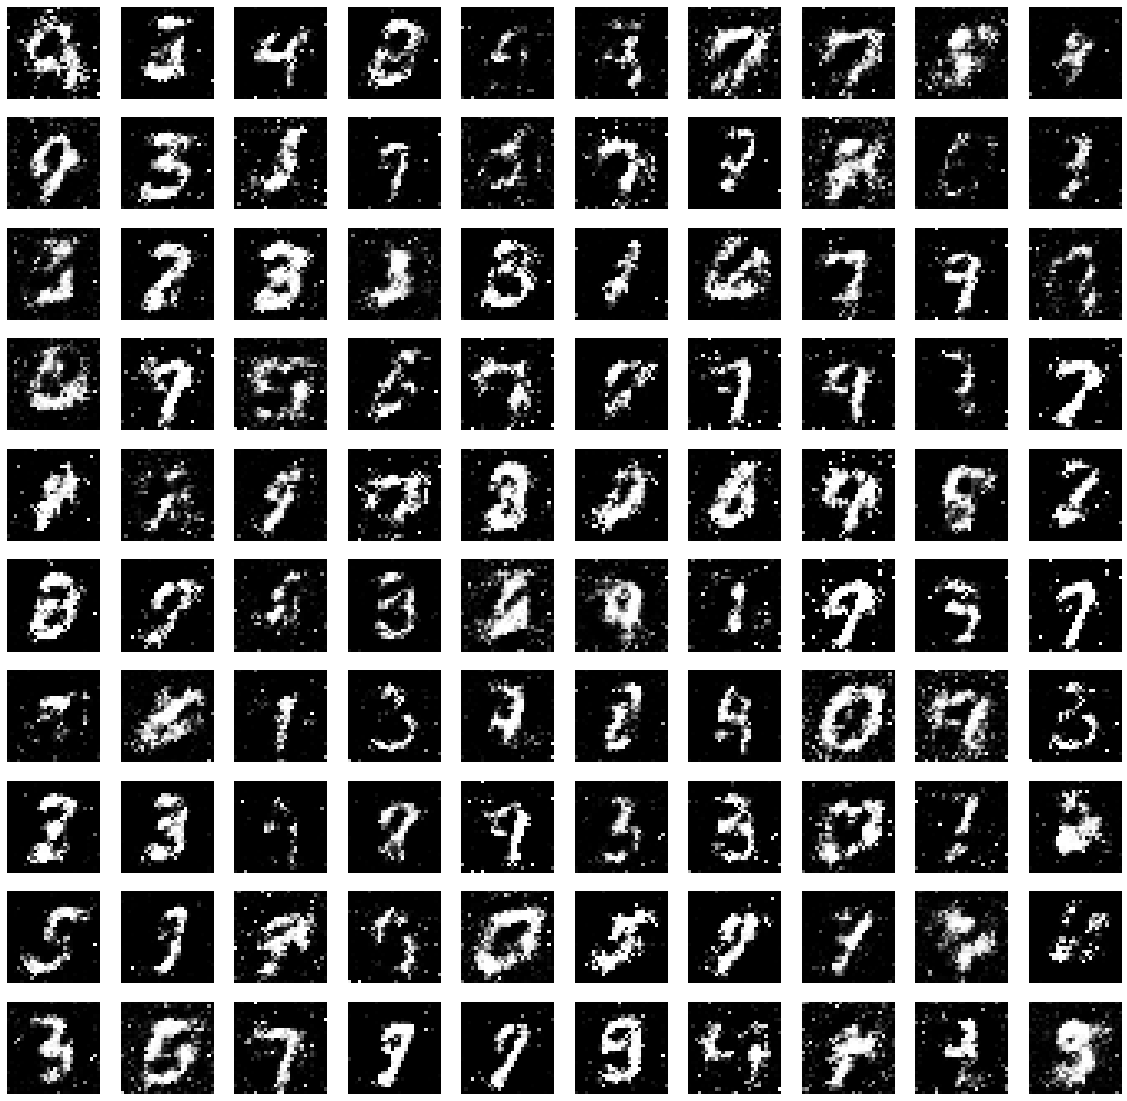

Epoch: 1, Generator Loss: 1.9169121980667114, Discriminator Loss: 0.5235182046890259


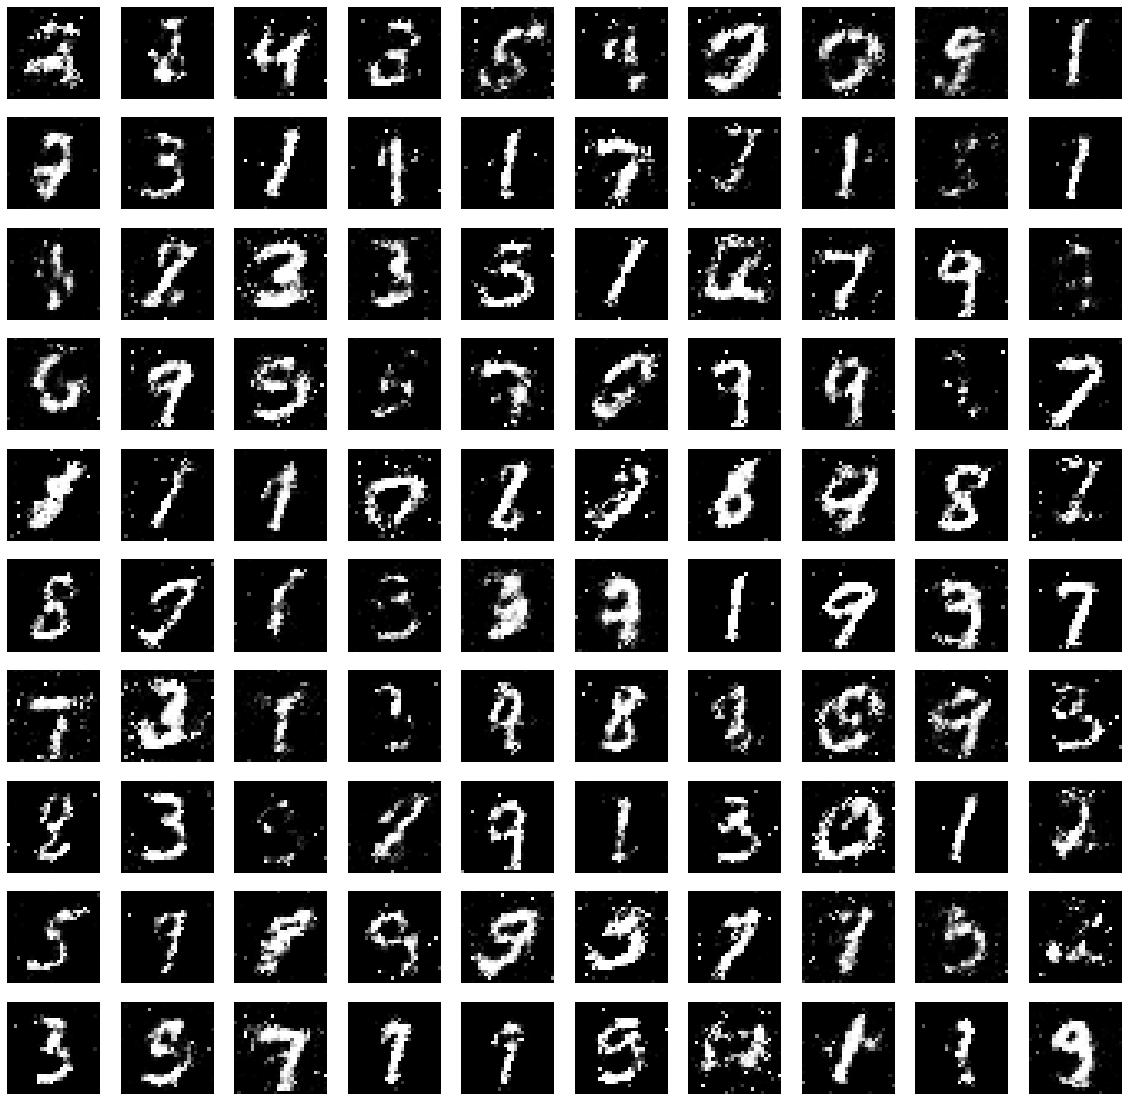

Epoch: 2, Generator Loss: 1.7649623155593872, Discriminator Loss: 0.4936109781265259


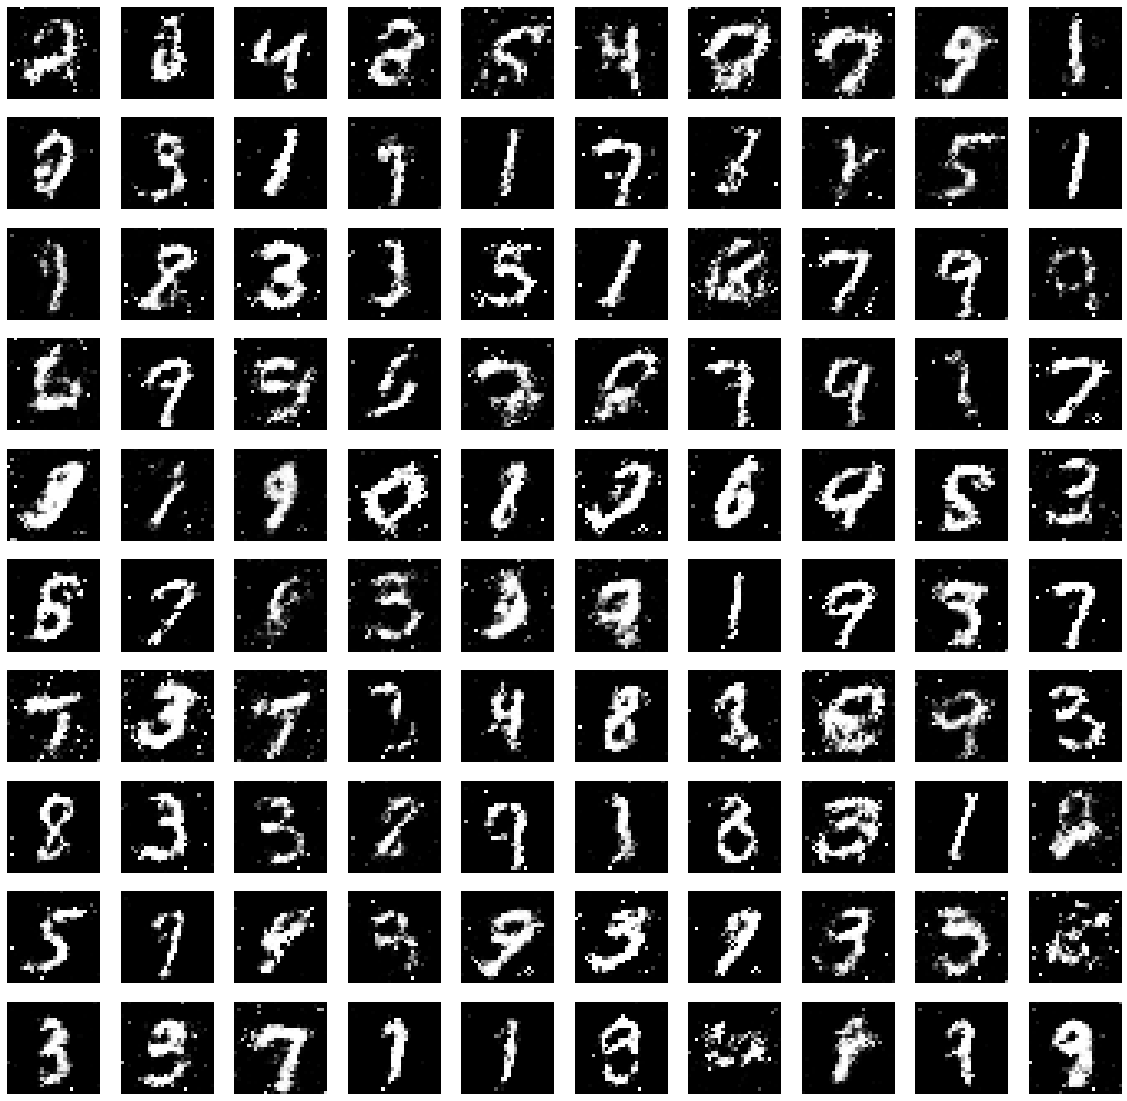

Epoch: 3, Generator Loss: 1.914363145828247, Discriminator Loss: 0.5585108995437622


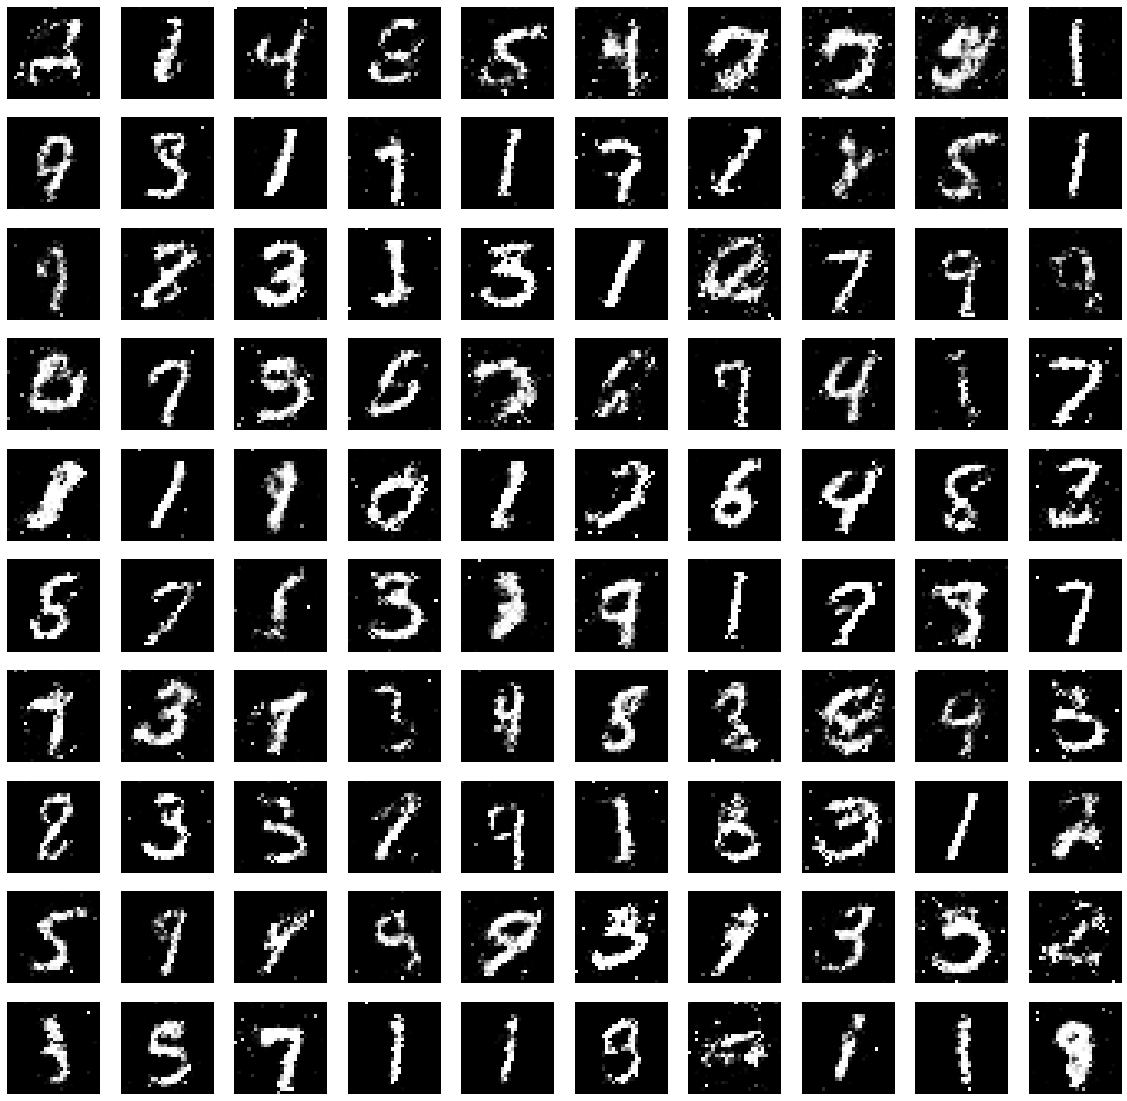

Epoch: 4, Generator Loss: 1.7229654788970947, Discriminator Loss: 0.5154737234115601


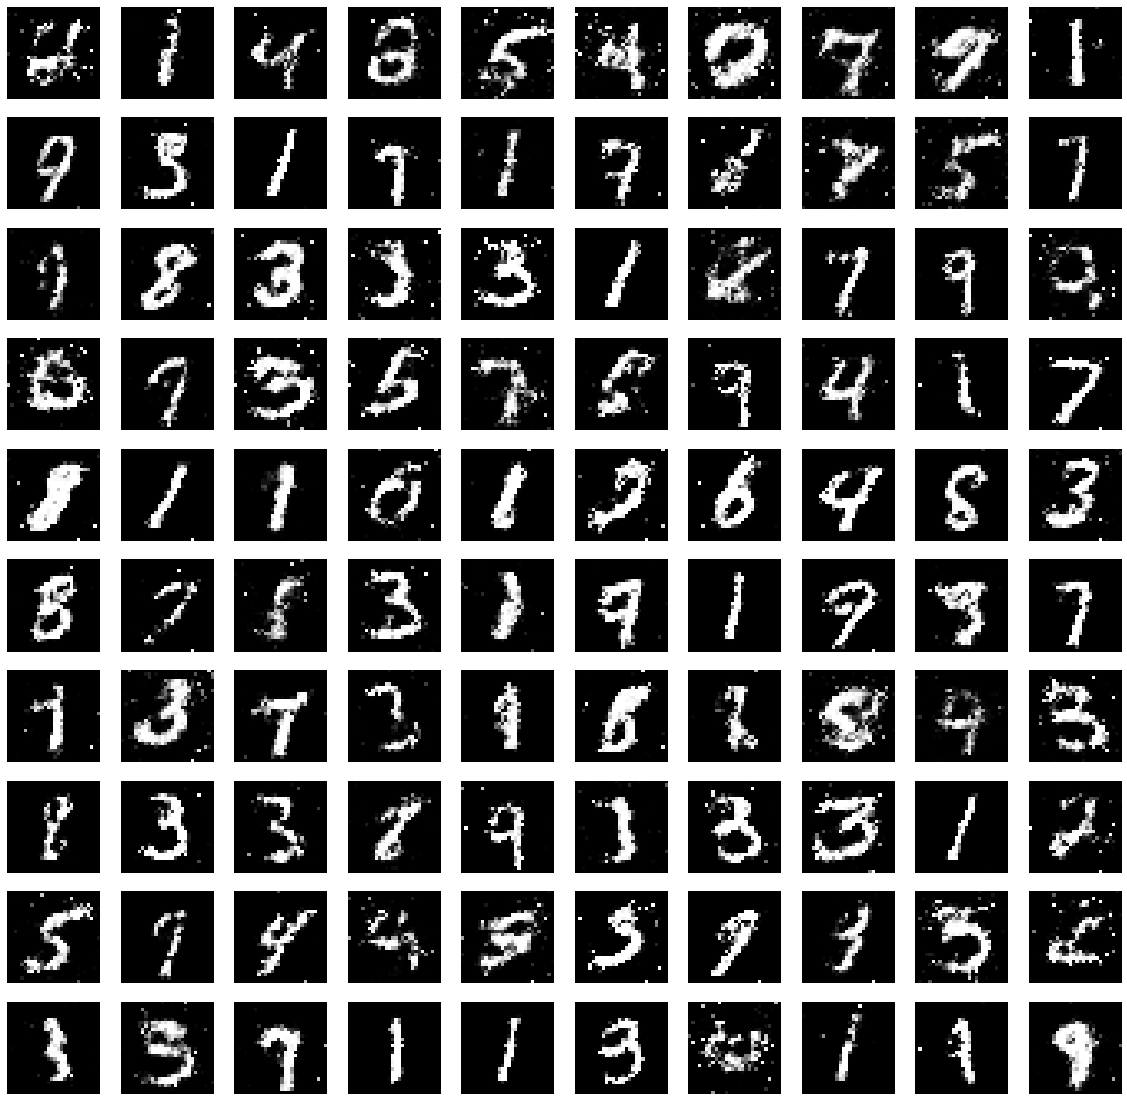

Epoch: 5, Generator Loss: 2.127858877182007, Discriminator Loss: 0.4170515239238739


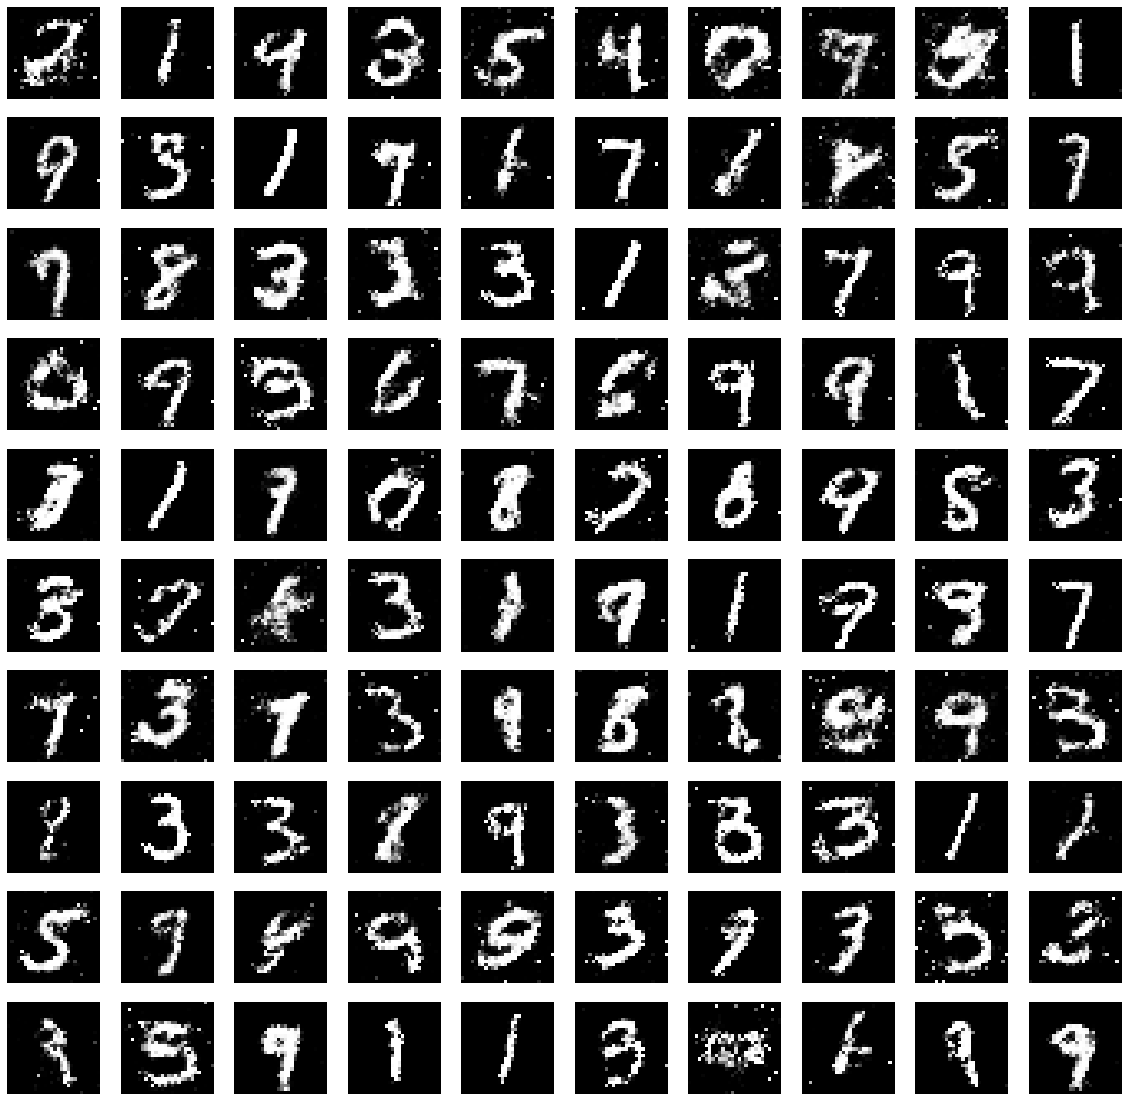

Epoch: 6, Generator Loss: 1.9200856685638428, Discriminator Loss: 0.5152108073234558


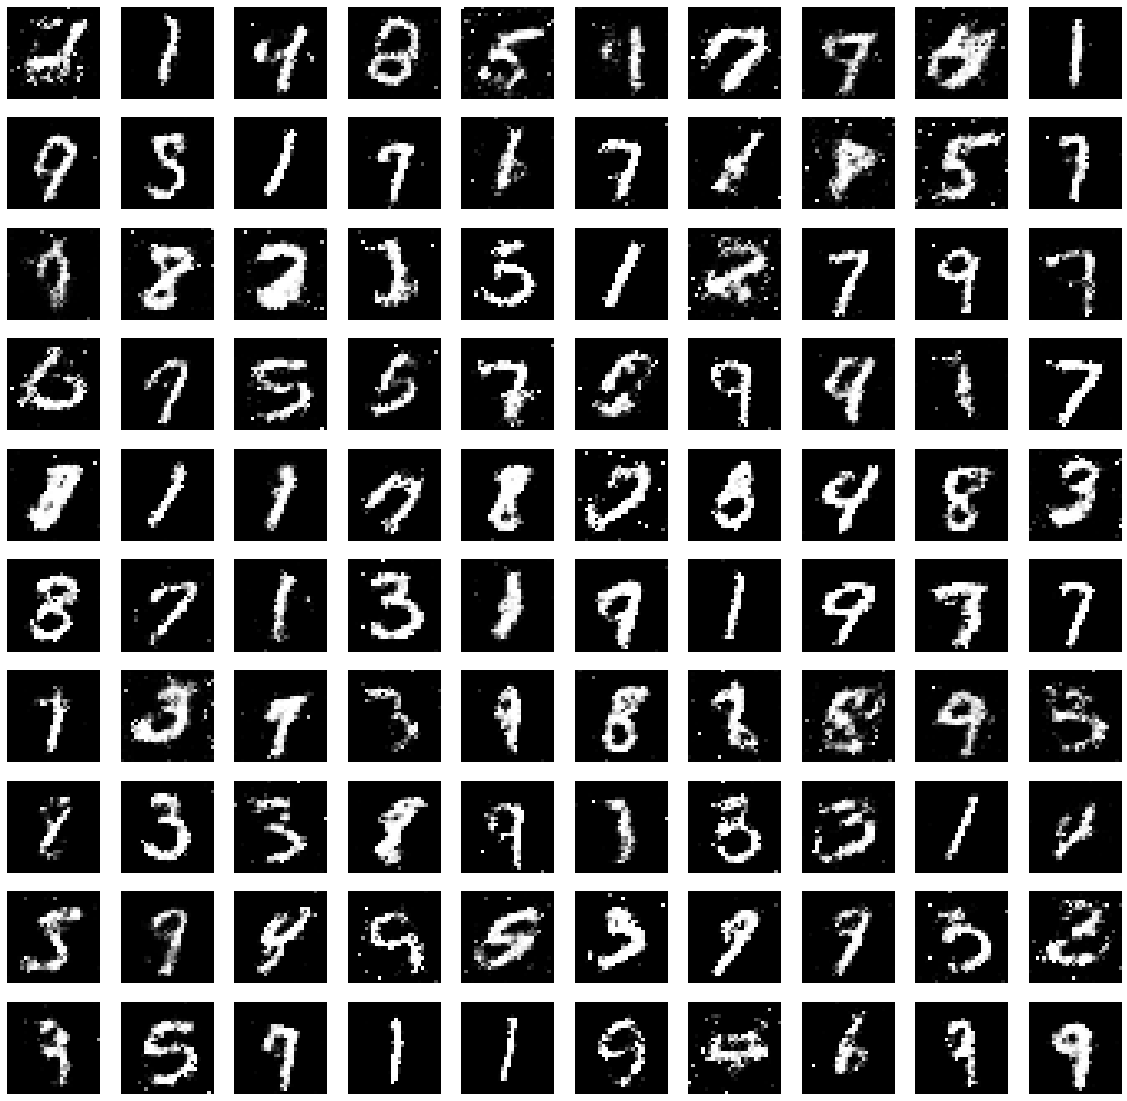

Epoch: 7, Generator Loss: 1.7070598602294922, Discriminator Loss: 0.5091201066970825


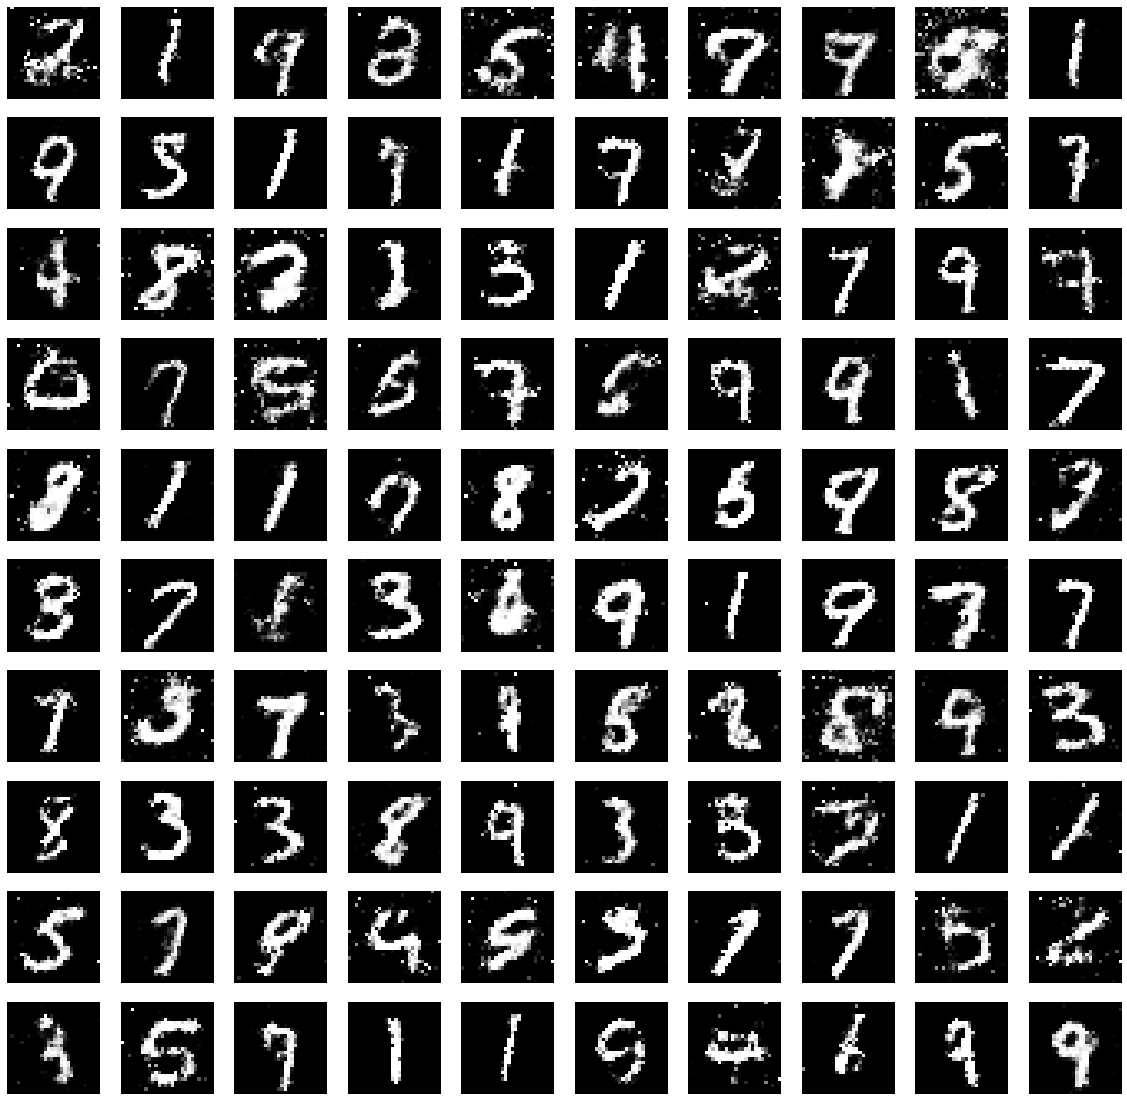

Epoch: 8, Generator Loss: 1.8964836597442627, Discriminator Loss: 0.5007620453834534


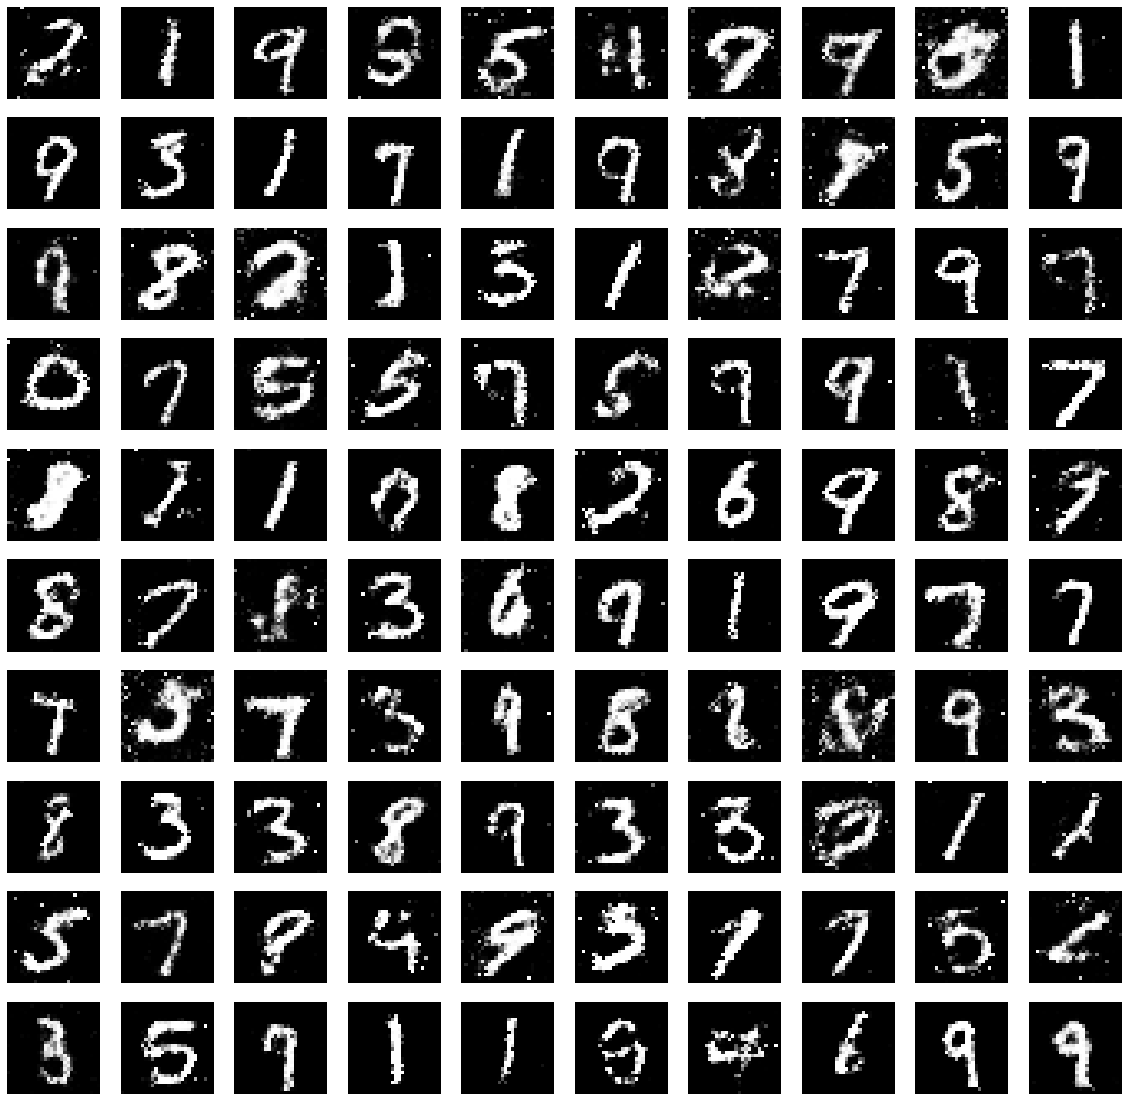

Epoch: 9, Generator Loss: 1.8756173849105835, Discriminator Loss: 0.5364683270454407


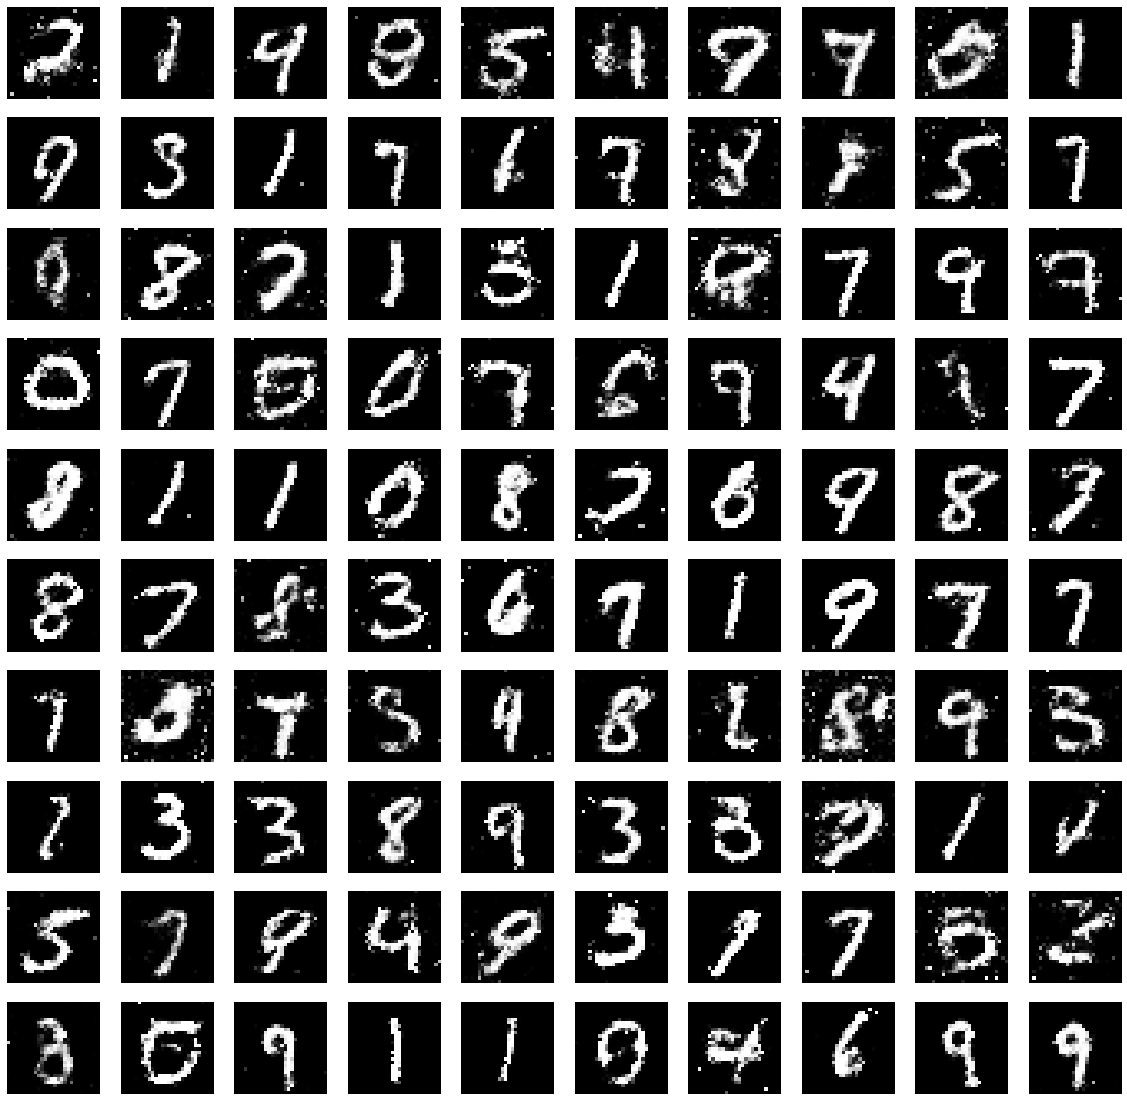

Epoch: 10, Generator Loss: 1.9351822137832642, Discriminator Loss: 0.4432372450828552


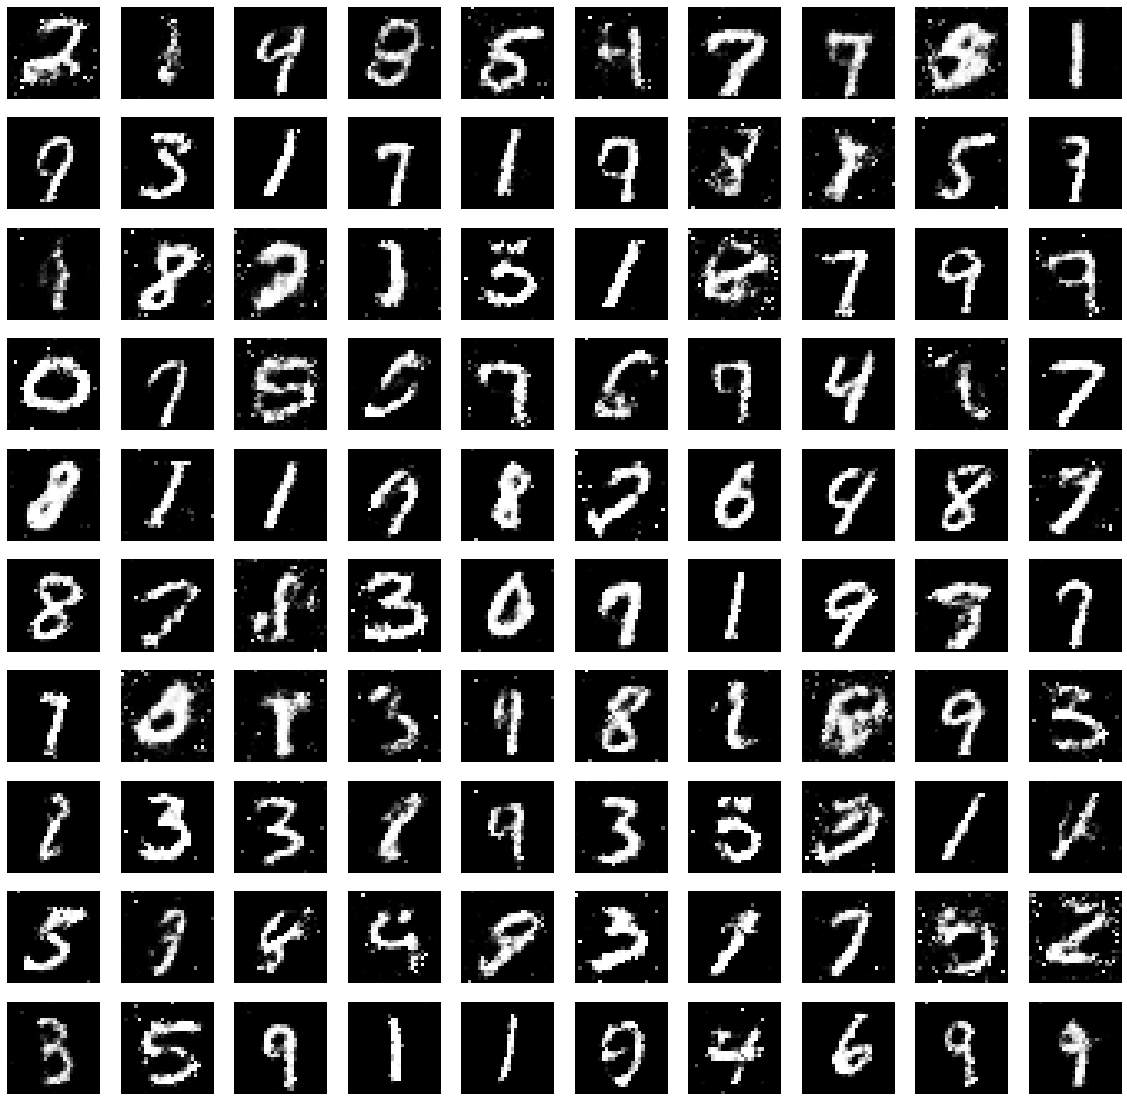

In [402]:
#training the model

#Same noise to generate sample images at benchmarks
n = np.random.normal(0, 1, size=(100, 100))

#Epochs and batch size
epochs = 11
batch_size = 16
steps = 60000//batch_size

#Repeat for each epoch
for epoch in range(epochs):
  #Repeat for each batch
  for batch in range(steps):
    #Generate random noise for input
    noise = np.random.normal(0, 1, size=(batch_size, 100))

    #Generate images from the random noise using the generator
    fake_x = generator.predict(noise)
    #Get a sample from the real images
    real_x = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    #Put the two together to input to the discriminator
    x = np.concatenate((real_x, fake_x))

    #Creating labels. We know the first half is fake the second half is real
    y=np.zeros(2*batch_size)
    #Instead of using 1 as the labels of the real images, we use 0.9 to avoif the discriminator getting overconfident
    y[:batch_size] = 0.9

    #Training the discriminator and getting its loss
    discriminator_loss = discriminator.train_on_batch(x, y)

    #Create opposite y labels for the generated data. This way we will update the generator so that minimizing the loss
    #will update the generator weights in a way that increases the discriminator inacurracy.
    y_gan = np.ones(batch_size)
    #Training the generator
    generator_loss = gan.train_on_batch(noise, y_gan)

  print('Epoch: ' + str(epoch) + ', Generator Loss: ' 
        + str(generator_loss) + ', Discriminator Loss: ' + str(discriminator_loss))

  show_images(n, epoch)

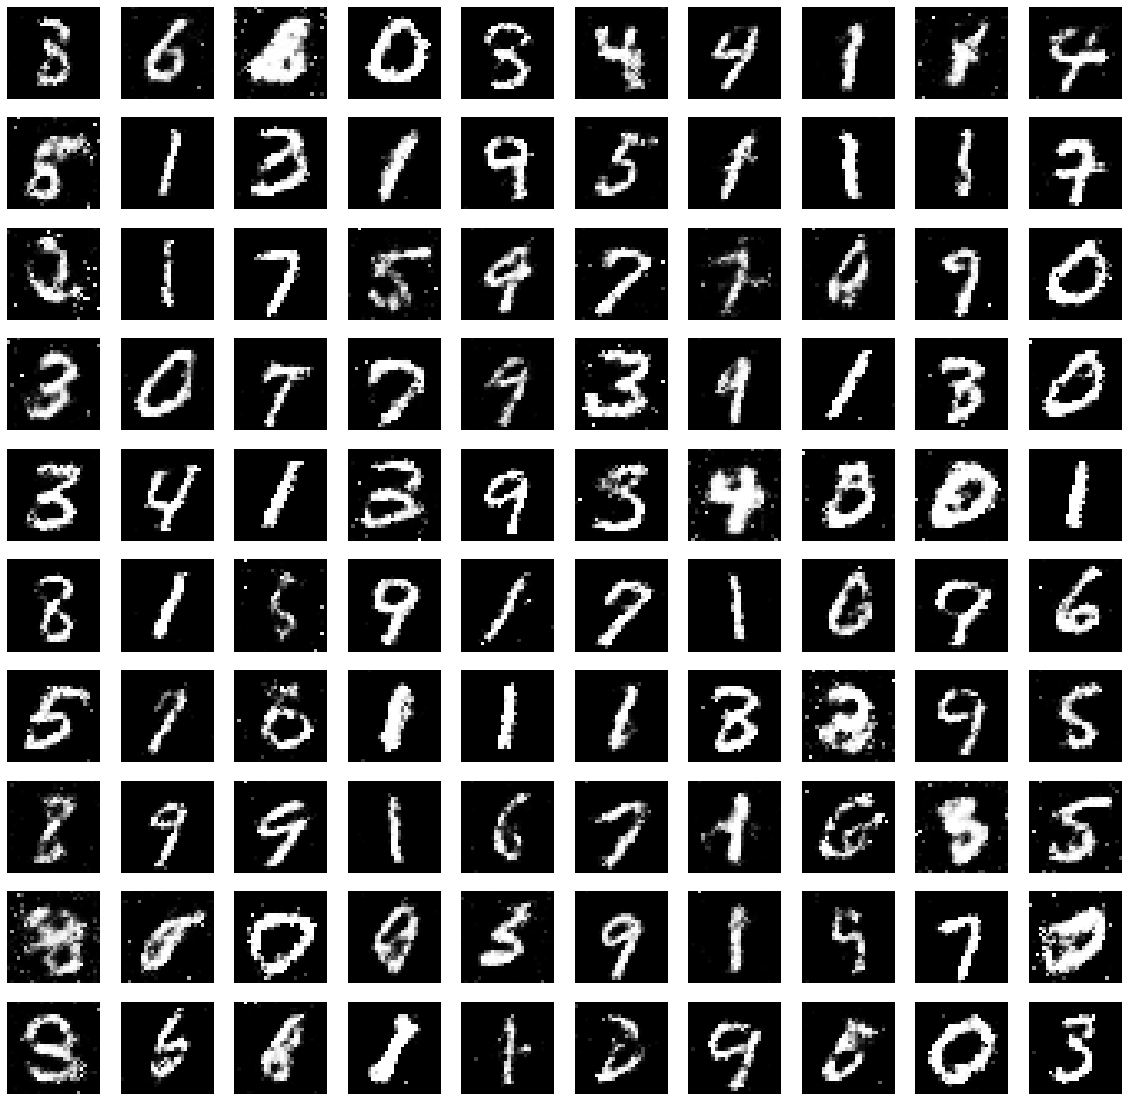

In [403]:
#A sample batch from the trained model
#Make sure to check out the GIF I made: https://gph.is/g/EG8DDpp
show_images(np.random.normal(0, 1, size=(100, 100)), 'final')

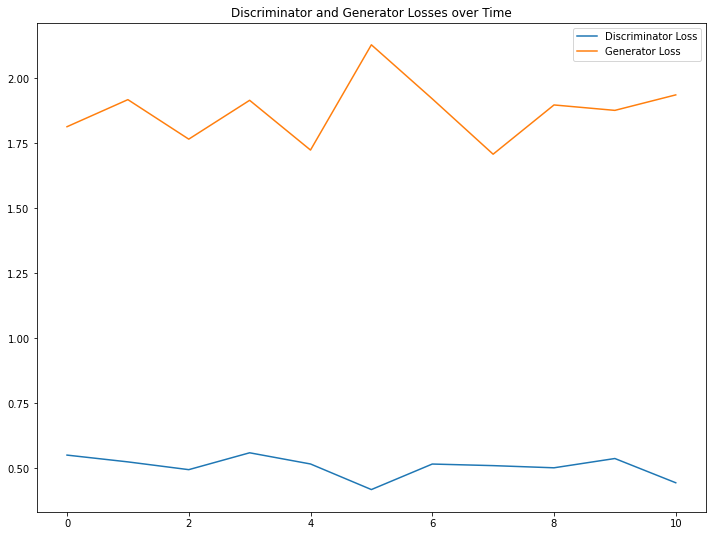

In [448]:
#Checking the losses (I forgot to save them during training so, I'll just copy-paste them)

discriminator_loss = [0.5496151447296143, 0.5235182046890259, 0.4936109781265259, 0.5585108995437622,  0.5154737234115601, 
                      0.4170515239238739, 0.5152108073234558, 0.5091201066970825, 0.5007620453834534, 0.5364683270454407, 
                      0.4432372450828552]
generator_loss = [1.812778353691101, 1.9169121980667114, 1.7649623155593872, 1.914363145828247, 1.7229654788970947, 
                  2.127858877182007, 1.9200856685638428, 1.7070598602294922, 1.8964836597442627, 1.8756173849105835, 
                  1.9351822137832642, ]

plt.figure(figsize=(12, 9))
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.plot(generator_loss, label='Generator Loss')
plt.title('Discriminator and Generator Losses over Time')
plt.legend()
plt.show()



### A Little Bit of a Discussion

When we look at the loss graphs we can see that the generator loss is between the range 1.75 and 2.25 and the discriminator loss is between 0.40 and 0.60. They go up and down as they learn to outperform the other one, which in turn leads the other one to improve. Therefore, as their losses go up and down we can see from the output the image quality constantly improves. We can keep them running for a longer time for even better images. However, the training process didn't always look like this while I was working on this project and I will go into some of these cases and mention how I tackled them. The final model outputs at every epoch looks like this (it is the same GIF as above in case you missed it): https://gph.is/g/EG8DDpp

While working on this project, I faced some obstacles while trying to produce digits that look like the actual dataset. My model had both a mode collapse and it failed to converge at different times. I tried a couple of things to avoid these. 

In my case the failure to converge was due to the high discriminator performance, where the generator couldn't catch up with it. I first had sigmoid activations, I replaced them with the LeakyReLU as it's a widely suggested option. I reduced the learning rate by a lot. I started with the default settings but I realized the default lr was 0.001 and I had to drop it down to 0.0002. Besides, I was working with a convolutional architecture for my discriminator, however, I also discarded this too eventually as in this case it gave the discriminator an unfair advantage (altough convolutions are usually very useful in GANs, especially while working with more complex images). I also set the labels of the real data to be 0.9 insead of 1 punishing overconfidence on the discriminator side. These were all the things I did to keep the game between the discriminator and the generator fair. You don't want to downgrade your discriminator too much as then the best possible image quality you will get eill be low, however, we also want to avoid an overperforming discriminator. Also, a mistake I initially did was to put an optimizer after the generator network which I realize was not ideal. Then I used just the optimizer at the end of the GAN to update the generator.

I also had a mode collapse. All of the images started to come out as 1s after a couple of epochs. When I searched online, I realized this was a very common problem while working with the MNIST dataset. This is potentially due to 1 being easier to form than the other digits. It is indeed a local optimum for our problem. To tackle with this, I also reduced the learning rate of the generator so that it doesn't rush to converge to something specific. I also reduced the batch sizes so in every update the model gets to work with a very small part of the data. Hopefully some of those batches omit some digits every now and then so that the generator cannot get away with repeating the same digit. 

Below you can see how both failure to converge and mode collapse look like

### Failing to Converge

Below are some examples of what happens when the model fails to converge. You can see that the ouput looks nothing like what we want it to be. Also, we can see that it converges to a single (or there are a couple of them at most) wrong output for all of the inputs. The generator in a way finds one output that is wrong but that somewhat temporarily increses discriminator loss. When the discriminator learns this output the generator jumps to a new one. They kind of play hide and seek, but the outputs are far from what we want them to be.

In [442]:
from PIL import Image

fail_to_converge=[]

for i in range(4):
  with Image.open('modecollapse/failtoconverge' + str(i+1) + '.png') as im:
    fail_to_converge.append(im.copy())

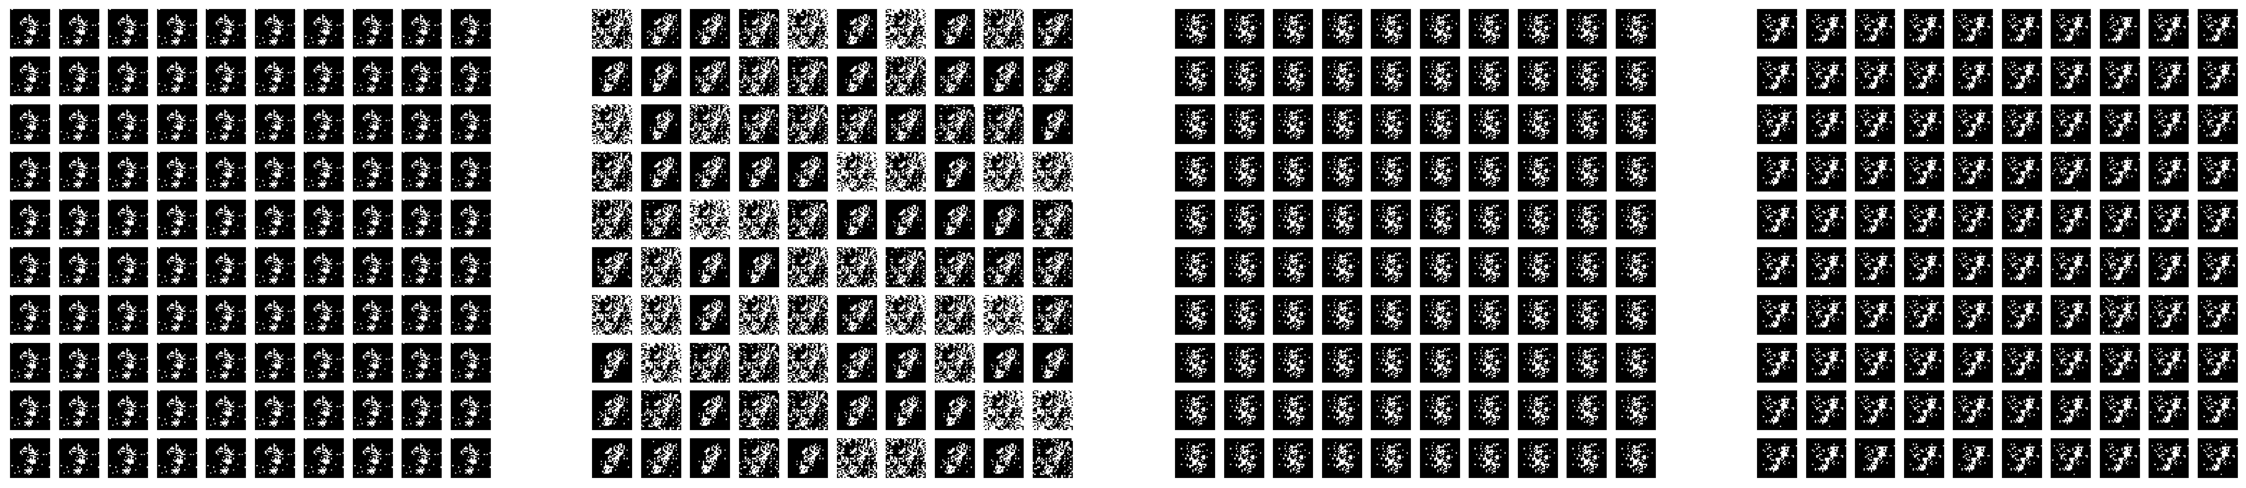

In [443]:
plt.figure(figsize = (40, 10))

  #Looping for each image
for i in range(4):
  #Creating a subplot
  plt.subplot(1, 4, 1 + i)
  plt.axis('off')

  #Plotting the image
  plt.imshow(fail_to_converge[i])
  

plt.show()

### Mode Collapse

Below you can see an example of what happens when we have mode collapse. See that the initial outputs resemble the numbers, however, with more training they all start to look like 1s.

In [440]:
modecollapse=[]

for i in range(4):
  with Image.open('modecollapse/modecollapse' + str(i+1) + '.png') as im:
    modecollapse.append(im.copy())

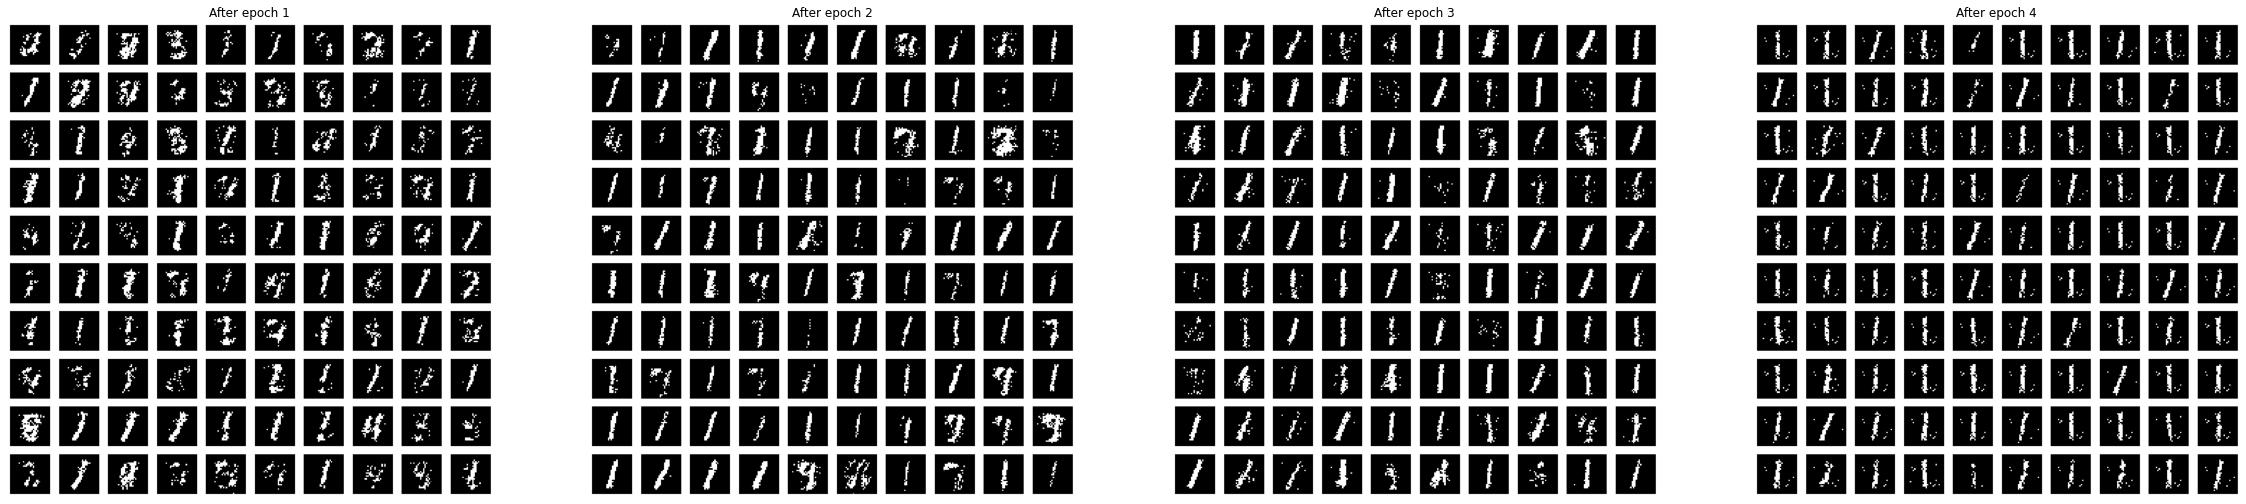

In [441]:
plt.figure(figsize = (40, 10))

  #Looping for each image
for i in range(4):
  #Creating a subplot
  plt.subplot(1, 4, 1 + i)
  plt.title('After epoch ' + str(i+1))
  plt.axis('off')

  #Plotting the image
  plt.imshow(modecollapse[i])
  

plt.show()

## Resources:

- https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
- https://anderfernandez.com/en/blog/how-to-code-gan-in-python/
- https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
- https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f